<a href="https://colab.research.google.com/github/Anusha-1224/image-captioning/blob/main/Copy_of_image_captioning_bert_21_04_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Captioning**

In [ ]:
import pip
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 28.3 MB/s 
     |████████████████████████████████| 132 kB 66.2 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 9.0 MB 51.5 MB/s 
     |████████████████████████████████| 139 kB 73.7 MB/s 
     |████████████████████████████████| 127 kB 68.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install bcolz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 29.9 MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp37-cp37m-linux_x86_64.whl size=2648213 sha256=a2567078fe8deba8691378a58692385aefdda83d5484e2ab7ba755485d83e067
  Stored in directory: /root/.cache/pip/wheels/2c/35/ca/9d914de345914e2446ea285170329f771b8abba2a00f7650bd
Successfully built bcolz


In [ ]:
#Load dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import required libraries
import tensorflow

# keras version
import keras
from PIL import Image
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


import torch
from torch import nn, optim
import torch.onnx
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

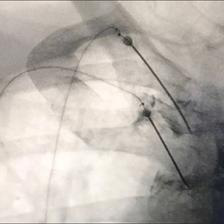

anteroposterior view of the final position of radio frequency needle below  and  thoracic pedicle after nonionic contrast injection.


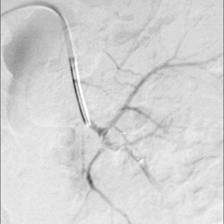

film after glue embolization show no filling in the pseudoaneurysm and the glue angiocatheter.


In [ ]:
#Defining function for sample input-output (from the Flickr dataset)
def display_random_data(count=5, seed=3):
    np.random.seed(seed)
    # random choose images == count
    images = np.random.choice(captions['image'].unique(), count)    
    # display and their captions
    for image in images:
        # display image
        display(Image.open(f'/content/drive/MyDrive/data/Training_Images/{image}'))
        # display caption
        img_captions = captions.loc[captions['image']==image, 'caption'].tolist()
        for cap in img_captions:
            print(cap)
display_random_data(2)

In [ ]:
#Reading the CSV file attached with our images from drive
captions = pd.read_csv("/content/drive/MyDrive/data/annotations/captions.csv")
captions

,image,caption
0,ImageCLEFmedCaption_2022_train_000001.jpg,pericardial tamponade with clear distinction o...
1,ImageCLEFmedCaption_2022_train_000002.jpg,angiography of the aortic arch show delay visu...
2,ImageCLEFmedCaption_2022_train_000003.jpg,balloonocclude retrograde transvenous oblitera...
3,ImageCLEFmedCaption_2022_train_000004.jpg,film after glue embolization show no filling i...
4,ImageCLEFmedCaption_2022_train_000005.jpg,peripheral in posteroanterior projection angio...
...,...,...
94,ImageCLEFmedCaption_2022_train_000096.jpg,selective catheterization with subsequent angi...
95,ImageCLEFmedCaption_2022_train_000097.jpg,a still from the cag show occlusion of the pr...
96,ImageCLEFmedCaption_2022_train_000098.jpg,selective leave renal artery angiography after...
97,ImageCLEFmedCaption_2022_train_000099.jpg,coronary angiogram show lmca lad and lcx with ...


In [ ]:
from collections import Counter

In [ ]:
#Read CSV file
#Read CSV file
df = pd.read_csv("/content/drive/MyDrive/data/annotations/captions.csv")
text = max(captions['caption'], key = len)
#res= max(len(ele) for ele in captions['caption'])
word_list = text.split()
max_number_of_words = len(word_list)
#print(text)
print(max_number_of_words)
#print(res)
MAX_CAPTION_LEN =max_number_of_words-1# Maximum caption length
print(MAX_CAPTION_LEN)
#MAX_CAPTION_LEN =MAX_CAPTION_LEN - 1
POOLING_FACTOR = 32 # Pooling factor

71
70


In [ ]:
"""
#Defining function for caption preprocessing
def transform_captions(captions):
    print(captions)
    transformed = [vocab[word.lower()] for word in word_tokenize(captions)]
    padded = [transform + [vocab["."]]*(MAX_CAPTION_LEN - len(transform) + 2) for transform in transformed]
    print(padded)
    #print(padded)
    return padded

def get_caption(caption_sequence):
    
    return " ".join([id_to_word[id_] for id_ in caption_sequence if id_ != vocab["."]])
"""

'\n#Defining function for caption preprocessing\ndef transform_captions(captions):\n    print(captions)\n    transformed = [vocab[word.lower()] for word in word_tokenize(captions)]\n    padded = [transform + [vocab["."]]*(MAX_CAPTION_LEN - len(transform) + 2) for transform in transformed]\n    print(padded)\n    #print(padded)\n    return padded\n\ndef get_caption(caption_sequence):\n    \n    return " ".join([id_to_word[id_] for id_ in caption_sequence if id_ != vocab["."]])\n'

In [ ]:
#Defining function for caption preprocessing
def transform_captions(captions):
    
    transformed = [[vocab[word.lower()] for word in word_tokenize(caption)] for caption in captions]
    print(len(transformed))
    padded = [transform + [vocab["."]]*(MAX_CAPTION_LEN - len(transform)) for transform in transformed]
    print(len(padded))
    #print(padded)
    return padded

def get_caption(caption_sequence):
    
    return " ".join([id_to_word[id_] for id_ in caption_sequence if id_ != vocab["."]])

In [ ]:
#Data preprocessing
#Defining function for reading the dataset
class My_Flickr1k(Dataset):
    def __init__(self, root_file, captions, transform=None):
    
        self.transform = transform
        self.root = root_file
        self.ids = captions
        
    def __getitem__(self, idx):
        
        image_path, caps = self.ids[idx]
        caplens = len(caps)
        imgs = Image.open(self.root+image_path)
        if self.transform: 
            imgs = self.transform(imgs)
        #print("image",image)
        #print("caption",caption)
        return imgs, caps, caplens
    
    def __len__(self):
        return self.ids.shape[0]

In [ ]:
#Building dataset vocabulary
def build_datasets_vocab(root_file, captions_file, transform, split=0.15):
    df = pd.read_csv(captions_file)
    
    vocab = {}
    def create_vocab(caption):
        tokens = [token.lower() for token in word_tokenize(caption)]
        for token in tokens: 
            if token not in vocab: 
                vocab[token] = len(vocab)
            
    df["caption"].apply(create_vocab)
    
    train, valid = train_test_split(df, test_size=split, random_state=42)
    return My_Flickr1k(root_file, train.values, transform), \
           My_Flickr1k(root_file, valid.values, transform), \
           vocab


In [ ]:
#To divide the sentence into a list of word download punkt package
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Compute training set,validation set and vocabulaory list
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
train_dataset, valid_dataset, vocab = build_datasets_vocab("/content/drive/MyDrive/data/Training_Images/", "/content/drive/MyDrive/data/annotations/captions.csv",transform)

id_to_word = {id_: word for word, id_ in vocab.items()}
#print(id_to_word[10])
#print("vocab",vocab.items())
#print(vocab.items()
#print(vocab.values())
#print(vocab)
#x='balloonocclude retrograde transvenous obliteration be attempt use a coaxial'
#print(vocab['.'])

In [ ]:
#print(vocab('pericardial'))

In [ ]:
train_dataset

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
from pytorch_pretrained_bert import BertTokenizer, BertModel
import pickle
import torchvision.models as models

In [ ]:
PAD = 0
START = 1
END = 2
UNK = 3

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
grad_clip = 5.
num_epochs = 4
batch_size = 32 
decoder_lr = 0.0004
#train_dataset = TensorDataset(inps, tgts)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
class loss_obj(object):
    def __init__(self):
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
BertModel = BertModel.from_pretrained('bert-base-uncased').to(device)
BertModel.eval()
"""
# Load GloVe
glove_vectors = pickle.load(open('glove.6B/glove_words.pkl', 'rb'))
glove_vectors = torch.tensor(glove_vectors)
"""

"\n# Load GloVe\nglove_vectors = pickle.load(open('glove.6B/glove_words.pkl', 'rb'))\nglove_vectors = torch.tensor(glove_vectors)\n"

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))

    def forward(self, images):
        out = self.adaptive_pool(self.resnet(images))
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out


In [ ]:
bert_model=True
glove_model=False
from_checkpoint = False

In [ ]:
class Decoder(nn.Module):

    def __init__(self, vocab_size, use_glove, use_bert):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.attention_dim = 512
        self.use_bert = use_bert

        if use_glove:
            self.embed_dim = 300
        elif use_bert:
            self.embed_dim = 768
        else:
            self.embed_dim = 512

        self.decoder_dim = 512
        self.vocab_size = vocab_size
        self.dropout = 0.5
        
        # soft attention
        self.enc_att = nn.Linear(2048, 512)
        self.dec_att = nn.Linear(512, 512)
        self.att = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # decoder layers
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.embed_dim + self.encoder_dim, self.decoder_dim, bias=True)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.f_beta = nn.Linear(self.decoder_dim, self.encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)

        # init variables
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
        if not use_bert:
            self.embedding = nn.Embedding(vocab_size, self.embed_dim)
            self.embedding.weight.data.uniform_(-0.1, 0.1)

            # load Glove embeddings
            if use_glove:
                self.embedding.weight = nn.Parameter(glove_vectors)

            # always fine-tune embeddings (even with GloVe)
            for p in self.embedding.parameters():
                p.requires_grad = True

    def forward(self, encoder_out, encoded_captions, caption_lengths):    
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        dec_len = [x-1 for x in caption_lengths]
        max_dec_len = max(dec_len)

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        # load bert or regular embeddings
        if not self.use_bert:
            embeddings = self.embedding(encoded_captions)
        elif self.use_bert:
            embeddings = []
            for cap_idx in  encoded_captions:
                
                # padd caption to correct size
                # while len(cap_idx) < max_dec_len:
                #    cap_idx.append(PAD)
                #print(cap_idx)   
                #cap = ' '.join([vocab.id_to_word[word_idx.item()] for word_idx in cap_idx])
                cap = ' '.join([id_to_word[word_idx.item()] for word_idx in cap_idx])
                cap = u'[CLS] '+cap
                
                tokenized_cap = tokenizer.tokenize(cap)                
                indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_cap)
                tokens_tensor = torch.tensor([indexed_tokens]).to(device)

                with torch.no_grad():
                    encoded_layers, _ = BertModel(tokens_tensor)

                bert_embedding = encoded_layers[11].squeeze(0)
                
                split_cap = cap.split()
                tokens_embedding = []
                j = 0

                for full_token in split_cap:
                    curr_token = ''
                    x = 0
                    for i,_ in enumerate(tokenized_cap[1:]): # disregard CLS
                        token = tokenized_cap[i+j]
                        piece_embedding = bert_embedding[i+j]
                        
                        # full token
                        if token == full_token and curr_token == '' :
                            tokens_embedding.append(piece_embedding)
                            j += 1
                            break
                        else: # partial token
                            x += 1
                            
                            if curr_token == '':
                                tokens_embedding.append(piece_embedding)
                                curr_token += token.replace('#', '')
                            else:
                                tokens_embedding[-1] = torch.add(tokens_embedding[-1], piece_embedding)
                                curr_token += token.replace('#', '')
                                
                                if curr_token == full_token: # end of partial
                                    j += x
                                    break                            

                cap_embedding = torch.stack(tokens_embedding)
                embeddings.append(cap_embedding)
  
            embeddings = torch.stack(embeddings)
            #print('embedding',embeddings)
        # init hidden state
        avg_enc_out = encoder_out.mean(dim=1)
        h = self.h_lin(avg_enc_out)
        c = self.c_lin(avg_enc_out)

        predictions = torch.zeros(batch_size, max_dec_len, vocab_size).to(device)
        alphas = torch.zeros(batch_size, max_dec_len, num_pixels).to(device)
        print("Embeddings shape = ",embeddings.size())
        for t in range(max(dec_len)):
            print("dl",max(dec_len))
            batch_size_t = sum([l > t for l in dec_len ])
            #print("dec_len", dec_len)
            # soft-attention
            enc_att = self.enc_att(encoder_out[:batch_size_t])
            dec_att = self.dec_att(h[:batch_size_t])
            att = self.att(self.relu(enc_att + dec_att.unsqueeze(1))).squeeze(2)
            alpha = self.softmax(att)
            attention_weighted_encoding = (encoder_out[:batch_size_t] * alpha.unsqueeze(2)).sum(dim=1)
        
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            print("batch_size_t = ",batch_size_t)
            print("t = ",t)
            batch_embeds = embeddings[:batch_size_t, t, :]            
            cat_val = torch.cat([batch_embeds.double(), attention_weighted_encoding.double()], dim=1)
            
            h, c = self.decode_step(cat_val.float(),(h[:batch_size_t].float(), c[:batch_size_t].float()))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            #print('prediction:', predictions)
            alphas[:batch_size_t, t, :] = alpha
            #print("yes")
        # preds, sorted capts, dec lens, attention wieghts
        return predictions, encoded_captions, dec_len, alphas

In [ ]:
train_model = True
valid_model = False

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)

if from_checkpoint:

    encoder = Encoder().to(device)
    decoder = Decoder(vocab_size=len(vocab),use_glove=glove_model, use_bert=bert_model).to(device)

    if torch.cuda.is_available():
        if bert_model:
            print('Pre-Trained BERT Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_bert')
            decoder_checkpoint = torch.load('./checkpoints/decoder_bert')
        elif glove_model:
            print('Pre-Trained GloVe Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_glove')
            decoder_checkpoint = torch.load('./checkpoints/decoder_glove')
        else:
            print('Pre-Trained Baseline Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_baseline')
            decoder_checkpoint = torch.load('./checkpoints/decoder_baseline')
    else:
        if bert_model:
            print('Pre-Trained BERT Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_bert', map_location='cpu')
            decoder_checkpoint = torch.load('./checkpoints/decoder_bert', map_location='cpu')
        elif glove_model:
            print('Pre-Trained GloVe Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_glove', map_location='cpu')
            decoder_checkpoint = torch.load('./checkpoints/decoder_glove', map_location='cpu')
        else:
            print('Pre-Trained Baseline Model')
            encoder_checkpoint = torch.load('./checkpoints/encoder_baseline', map_location='cpu')
            decoder_checkpoint = torch.load('./checkpoints/decoder_baseline', map_location='cpu')

    encoder.load_state_dict(encoder_checkpoint['model_state_dict'])
    decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)
    decoder.load_state_dict(decoder_checkpoint['model_state_dict'])
    decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])
else:
    encoder = Encoder().to(device)
    decoder = Decoder(vocab_size=len(vocab),use_glove=glove_model, use_bert=bert_model).to(device)
    decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
"""
for epoch in tqdm(range(EPOCHS)):
    t = tqdm(train_dataloader, desc=f"Train: Epoch {epoch}")
    
    for images, captions, caplen in t:
        images = images.to(device)
"""
def train():
    print("Started training...")
    for epoch in tqdm(range(num_epochs)):
        decoder.train()
        encoder.train()

        losses = loss_obj()
        num_batches = len(train_dataloader)

        for i, (imgs, caps, caplens) in enumerate(tqdm(train_dataloader)):
        #for i, (imgs, caps, caplens) in tqdm(train_dataloader):
            imgs = encoder(imgs.to(device))
            caps = torch.LongTensor(transform_captions(caps)).to(device)

            scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]

            targets = caps_sorted[:, 1:]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            loss = criterion(scores, targets).to(device)

            loss += ((1. - alphas.sum(dim=1)) ** 2).mean()

            decoder_optimizer.zero_grad()
            loss.backward()

            # grad_clip decoder
            for group in decoder_optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

            decoder_optimizer.step()

            losses.update(loss.item(), sum(decode_lengths))

            # save model each 100 batches
            if i%5000==0 and i!=0:
                print('epoch '+str(epoch+1)+'/4 ,Batch '+str(i)+'/'+str(num_batches)+' loss:'+str(losses.avg))
                
                 # adjust learning rate (create condition for this)
                for param_group in decoder_optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * 0.8

                print('saving model...')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': decoder.state_dict(),
                    'optimizer_state_dict': decoder_optimizer.state_dict(),
                    'loss': loss,
                    }, './checkpoints/decoder_mid')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': encoder.state_dict(),
                    'loss': loss,
                    }, './checkpoints/encode_mid')

                print('model saved')

        torch.save({
            'epoch': epoch,
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': loss,
            }, './checkpoints/decoder_epoch'+str(epoch+1))

        torch.save({
            'epoch': epoch,
            'model_state_dict': encoder.state_dict(),
            'loss': loss,
            }, './checkpoints/encoder_epoch'+str(epoch+1))

        print('epoch checkpoint saved')

    print("Completed training...")  
  

In [ ]:
if train_model:
    train()



Started training...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

32
32
Embeddings shape =  torch.Size([32, 71, 768])
dl tensor(266)
batch_size_t =  tensor(32)
t =  0
dl tensor(266)
batch_size_t =  tensor(32)
t =  1
dl tensor(266)
batch_size_t =  tensor(32)
t =  2
dl tensor(266)
batch_size_t =  tensor(32)
t =  3
dl tensor(266)
batch_size_t =  tensor(32)
t =  4
dl tensor(266)
batch_size_t =  tensor(32)
t =  5
dl tensor(266)
batch_size_t =  tensor(32)
t =  6
dl tensor(266)
batch_size_t =  tensor(32)
t =  7
dl tensor(266)
batch_size_t =  tensor(32)
t =  8
dl tensor(266)
batch_size_t =  tensor(32)
t =  9
dl tensor(266)
batch_size_t =  tensor(32)
t =  10
dl tensor(266)
batch_size_t =  tensor(32)
t =  11
dl tensor(266)
batch_size_t =  tensor(32)
t =  12
dl tensor(266)
batch_size_t =  tensor(32)
t =  13
dl tensor(266)
batch_size_t =  tensor(31)
t =  14
dl tensor(266)
batch_size_t =  tensor(31)
t =  15
dl tensor(266)
batch_size_t =  tensor(31)
t =  16
dl tensor(266)
batch_size_t =  tensor(31)
t =  17
dl tensor(266)
batch_size_t =  tensor(30)
t =  18
dl tenso

IndexError: ignored